# Lecture 7: Training III

![](https://www.tensorflow.org/images/colab_logo_32px.png)
[Run in colab](https://colab.research.google.com/drive/151rKfOzxrWMK7fiViIGsosquddN07yJg )

In [14]:
import datetime
now = datetime.datetime.now()
print("Last executed: " + now.strftime("%Y-%m-%d %H:%M:%S"))

Last executed: 2024-02-07 20:51:54


## Polynomial regression

So far we have considered only linear regression.  Polynomial regression can also be performed with a model that is linear (in the parameters).

In [15]:
# Common imports
import os
import numpy as np
np.random.seed(42) # To make this notebook's output stable across runs

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

### Example data

In [16]:
import numpy.random as rnd
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

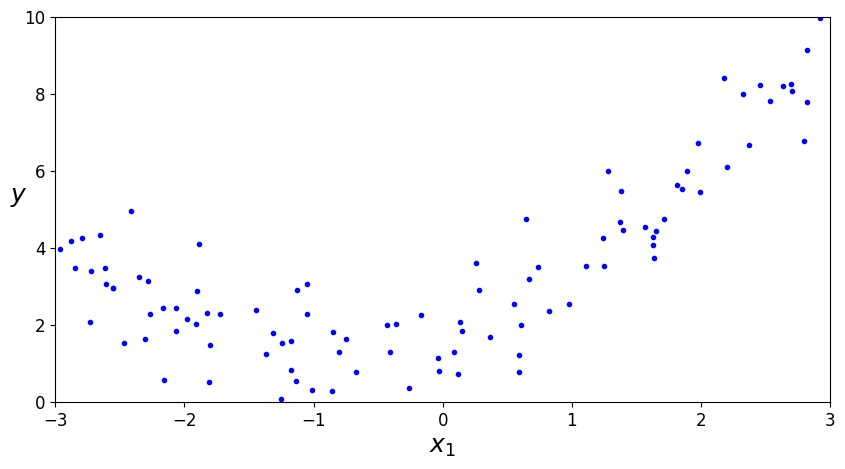

In [17]:
plt.figure(figsize=(10,5))
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10]);

Clearly a straight line will not fit the data well.

### Construct new features

Can use a linear model by constructing additional features that are powers of existing features:

$$\hat{y} = \theta_0 + \theta_1 x_1 + \theta_2 x_1^2 + \theta_3 x_2 + \theta_4 x_2^2 + \theta_5 x_1 x_2 + ... $$

Model remains linear in the parameters $\theta_j$.



### Generate polynomial features

In [18]:
from sklearn.preprocessing import PolynomialFeatures
# degree = 2 -> poly equation up to power of 2
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
print(poly_features.get_feature_names_out())
X_poly[0]

['x0' 'x0^2']


array([-0.75275929,  0.56664654])

In [19]:
X.shape, X_poly.shape

((100, 1), (100, 2))

### Fit model

In [20]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

Parameters are close to the model used to generate the data (2, 1 and 0.5 respectively).

### Predictions

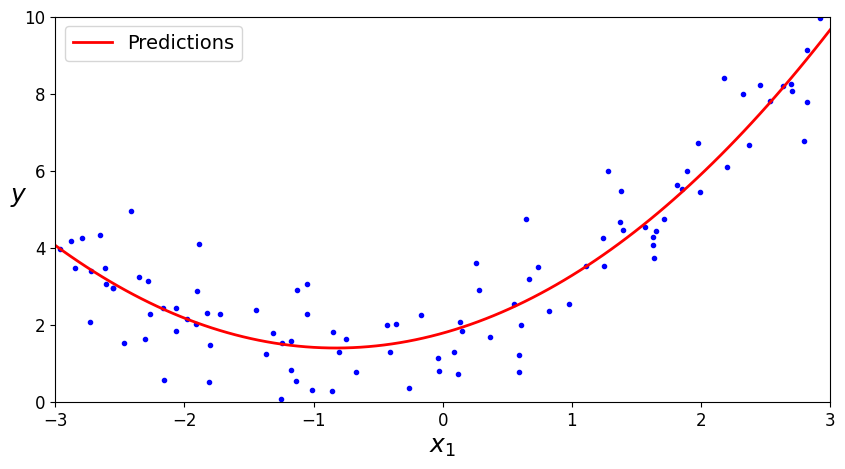

In [21]:
X_new = np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.figure(figsize=(10,5))
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10]);

**Exercises:** *You can now complete Exercise 1 in the exercises associated with this lecture.*

## Learning curves

How determine whether overfitting or underfitting?

### Overfitting with high degree polynomials

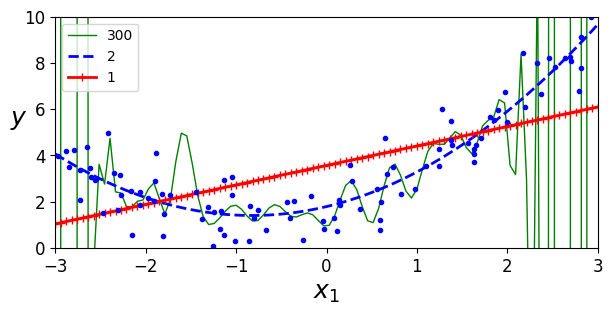

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

plt.figure(figsize=(7,3))
for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline(
        (("poly_features", polybig_features), ("std_scaler", std_scaler), ("lin_reg", lin_reg)) )
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10]);

Training data is underfitted for degree 1, fitted well for degree 2, and overfitted for degree 300.
The curve with degree 300 tried to fit with the noise leaning to unaccuracy

Learning curves provide another way to determine whether model underfitted or overfitted.

Consider performance on training and validation set *as size of the training set increases*.

### Plotting learning curves

In [23]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train_predict, y_train[:m]))
        val_errors.append(mean_squared_error(y_val_predict, y_val))

    plt.figure(figsize=(8,4))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="Training set")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
    plt.legend(loc="upper right", fontsize=14)   
    plt.xlabel("Training set size", fontsize=14) 
    plt.ylabel("RMSE", fontsize=14)              

### Underfitted learning curves

#### Learning curve for linear model

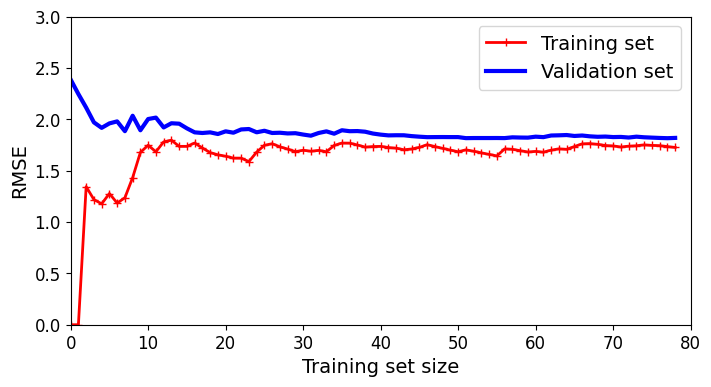

In [24]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3]);

- RMSE on training set small for small training set size since model can fit data well for very few data points (perfect for one or two points).

- RMSE performance on training and validation eventually similar but high since linear model cannot fit the data well (recall data generated by quadratic).

- With very small smaple size, let say 2, the linear regression can fit perfectly, leading to no/extremely low error

### Overfitted learning curves  

#### Learning curve for poynomial model of degree 10

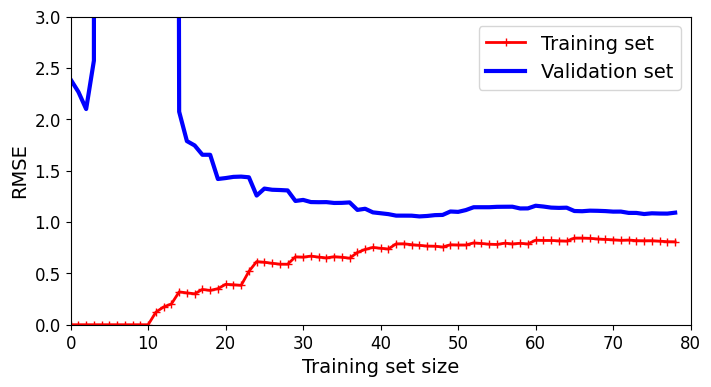

In [25]:
from sklearn.pipeline import Pipeline
polynomial_regression = Pipeline((
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ))
plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3]);  

- RMSE now much smaller.
- But training and validation set errors remain quite different.

Model performs much better on training set than validation set, suggesting overfitting.

### Well-fitted learning curves  

#### Learning curve for poynomial model of degree 2

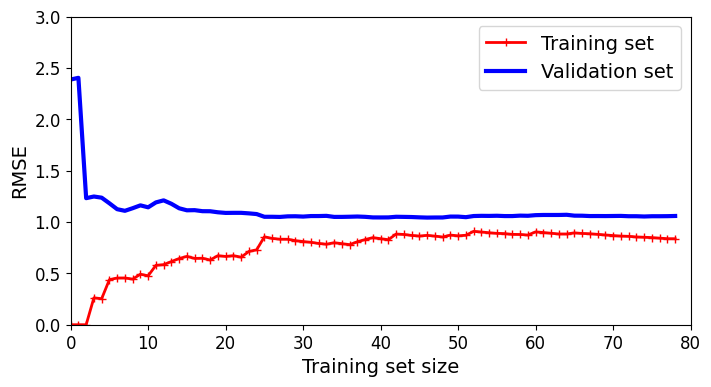

In [26]:
from sklearn.pipeline import Pipeline
polynomial_regression = Pipeline((
        ("poly_features", PolynomialFeatures(degree=2, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ))
plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3]);  

## Bias-variance tradeoff

Bias-variance tradeoff refers to the problem of simultaneously reducing the two types of errors that prevents supervised learning algorithms from generalising to other data.

- **Bias**: Expected difference between data and prediction.

- **Variance**: Expected ability of the model to fluctuate.

One seeks a model that accurately fits the training data, while also generalising to unseen data.

Typically impossible to do both simultaneously.

- On one hand, high-variance models may fit training data well but typically overfit to noise or unrepresentative training data.

- On the other hand, low-complexity models with a high bias typically underfit training data.




### Contributions to the mean square error 

Consider underlying (true) model:
$ y = f(x) + \epsilon,$

where
- $y$ is the target and $x$ features.
- $f$ is the true model, that we will approximate by $h$.
- $\epsilon$ is the noise, with zero mean and variance $\sigma^2$.


Approximate $f$ by $h$, which is fitted by a learning algorithm and training data.

Expected value of the mean square error is given by

$$\text{E} \left[ \left(y - h(x)\right)^2 \right]
= 
\text{Bias}^2\left[ h(x) \right]
+
\text{Var}\left[ h(x) \right]
+
\sigma^2$$

Three contributions to the error:
 
1. Bias: $\text{Bias}\left[ h(x) \right] = \text{E} \left[ h(x) - f(x) \right].$ how well does the model fit

3. Variance:  $\text{Var}\left[ h(x) \right] =  \text{E} \left[ h^2(x)\right] - \text{E} \left[ h(x)\right]^2. $

4. Irreducible error $\sigma^2$ due to noise in observations.

### Tradeoff 

By choosing a complex model, the bias can be made small but the variance will be large.

By choosing a simple model, the variance can be made small but the bias will be large.

<img src="https://raw.githubusercontent.com/astro-informatics/course_mlbd_images/master/Lecture07_Images/biasvariance.png" width="700px" style="display:block; margin:auto"/> 

[Image source](http://francescopochetti.com/bias-v-s-variance-tradeoff/)

## Regularization

One approach to mitigate the bias-variance tradeoff is by *regularization*.

Consider a complex model but place additional constraints to reduce its variance.

As a consequence the bias is increased but can introduce a regularisation parameter to control the tradeoff.

Add regularization term $R(\theta)$ to the cost function:

aims to minimise the cost function

$$C_\lambda(\theta) = C(\theta) + \lambda\ R(\theta).$$

The regularization parameter $\lambda$ controls the amount of regularization.
lambda is the penality of high complexity, (just introduced for training not for validation)


Regularization should only be added when training.  When using fitted model to make predictions, should evaluate cost without regularization term.

### Tikhonov regularization 

*Tikhonov* regularization adopts $\ell_2$ regularising term (also called *Ridge regression*):

$$ R(\theta) = \frac{1}{2} \sum_{j=1}^n \theta_j^2 = \frac{1}{2}  \theta^{\rm T}\theta.$$



Acts to keep parameters small.

Note that the bias term $\theta_0$ is not regularized (i.e. sum starts from 1 not 0).

In [27]:
from sklearn.linear_model import Ridge

np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

def plot_model(model_class, polynomial, alphas, **model_kargs): 
    # Use alpha for regularization parameter (lambda used already)
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline((
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ))
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\lambda = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

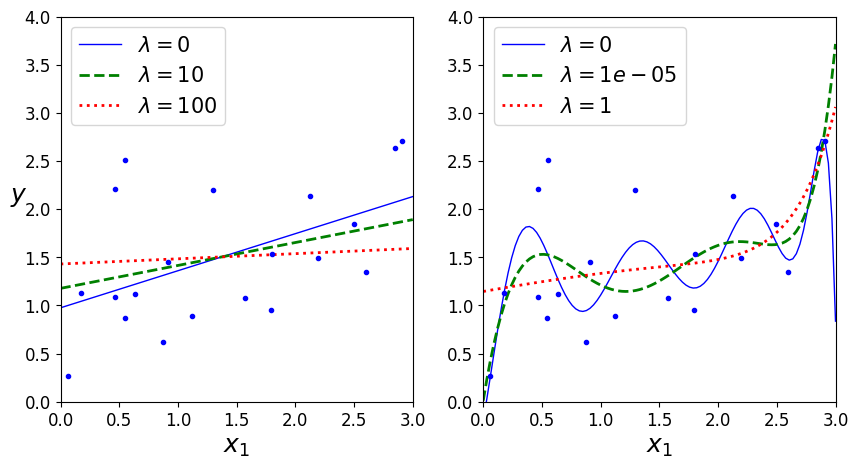

In [29]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

**Exercises:** *You can now complete Exercises 2 and 3 in the exercises associated with this lecture.*

### Lasso regularization


*Lasso* regularization adopts $\ell_1$ regularising term:

$$ R(\theta) =\sum_{j=1}^n \left\vert \theta_j \right\vert .$$

Acts to promote sparsity.

Again, note that the bias term $\theta_0$ is not regularized (i.e. sum starts from 1 not 0).



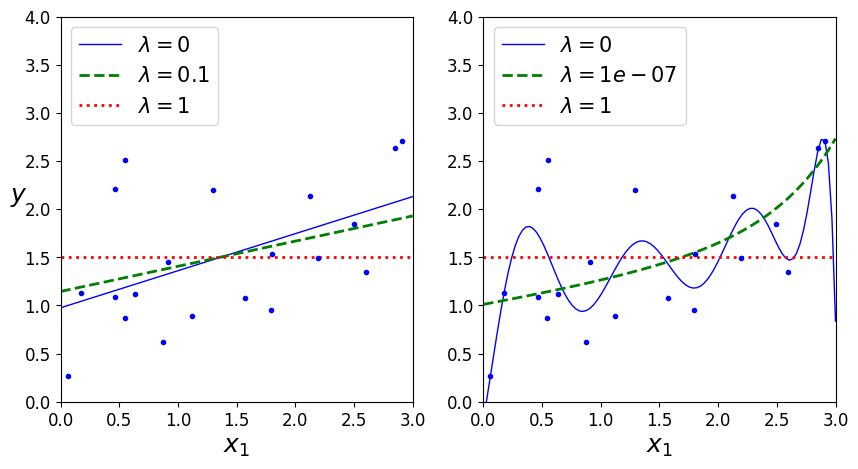

In [16]:
from sklearn.linear_model import Lasso

plt.figure(figsize=(10,5))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), tol=1, random_state=42)

#### Differentiability

Note that the Lasso penality is non-differentiable at zero.

Gradient descent can still be used but with gradients replaced by [sub-gradients](https://en.wikipedia.org/wiki/Subderivative) when any $\theta_j=0$.

### Elastic Net regularization


Provides a mix of Tikhonov and Lasso regularization, controlled by mix ratio $r$:

$$R(\theta)
= 
r\sum_{j=1}^n \left\vert \theta_j \right\vert
+
\frac{1-r}{2} \sum_{j=1}^n \theta_j^2.$$

- For $r=0$, corresponds to Tikhonov regularization.
- For $r=1$, corresponds to Lasso regularization.

### Stopping early

Compute RMSE on validation set as train and stop when starts to increase.

In [17]:
from sklearn.linear_model import SGDRegressor
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

poly_scaler = Pipeline((
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler()),
    ))

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1,
                       penalty=None,
                       eta0=0.0005,
                       warm_start=True,
                       learning_rate="constant",
                       random_state=42)

In [18]:
import warnings
warnings.filterwarnings(action='ignore')
n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train_predict, y_train))
    val_errors.append(mean_squared_error(y_val_predict, y_val))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

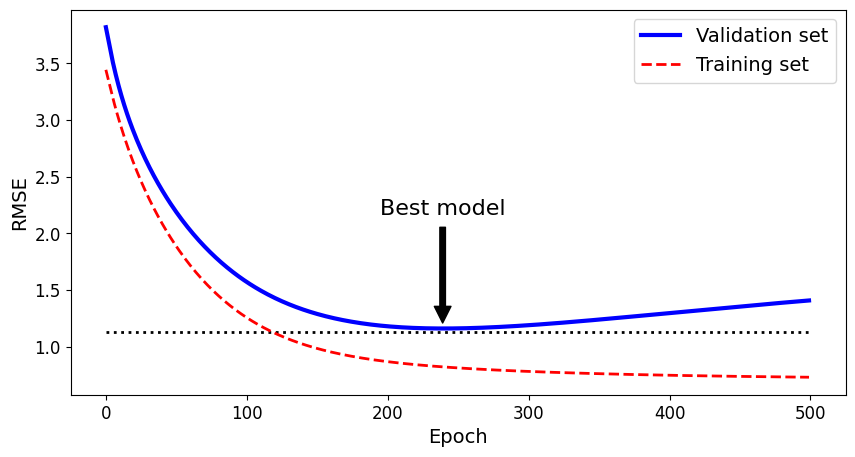

In [19]:
plt.figure(figsize=(10,5))
plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14);

Note that for stochastic or mini-batch gradient descent the RMSE is noisy and may be difficult to know when reach minimum (can employ simple strategies to deal with that).